<sub><sup>Copyright (C) 2025 J. Heinzmann, A. Benady, ETH Zürich</sub></sup>

<sub><sup>
This file is part of the `nlfea` package for the course Computational Mechanics II: Nonlinear FEA at ETH Zurich.
This software is exclusively intended for personal, educational purposes only in the context of the above course.
It must not be used outside of this scope without the explicit consent of the author(s).
</sub></sup>

# Project 3

The third project revolves around the FE implementation of non-linear continuum mechanics and hyperelasticity.

This notebook will guide you through all the necessary steps.

## 1. Implementation of non-linear continuum mechanics

We start with the implementation of continuum elements with large deformations.
For this, we'll use a simple rectangular block under tension with a St. Venant Kirchhoff material model for which we create the setup below.

In [1]:
# external dependencies
import numpy as np

# internal dependencies
from nlfea import Model, Solver, mesh, materials, elements, solution, post

# initialize empty model object
model_SVK = Model()

# mesh
W = 10
L = 100
(model_SVK.nodes, model_SVK.connectivity) = mesh.plane.rectangle(
    length_x=W, length_y=L, num_nodes_x=10, num_nodes_y=50, element_type="quad4"
)

# define material model
model_SVK.material = materials.StVenantKirchhoff(λ=121, μ=80)

# define type of element
model_SVK.parent_element = elements.Quad(
    kinematics="nonlinear", element_type="quad4", integration="full"
)


# find node sets for the application of BCs
bottom_edge = mesh.nodesets.find(model_SVK.nodes, Y=0)
bottom_leftcorner = mesh.nodesets.find(model_SVK.nodes, X=0, Y=0)
top_edge = mesh.nodesets.find(model_SVK.nodes, Y=L)

# Dirichlet BCs
model_SVK.dirichlet_bcs = (("fix_X", bottom_leftcorner), ("fix_Y", bottom_edge))

# Neumann BCs
t_bar = 100
model_SVK.neumann_bcs = (("t_Y", top_edge, t_bar),)

# solver parameters
solver_SVK = Solver()
solver_SVK.num_increments = 10
solver_SVK.tolerance_nr = 1e-7
solver_SVK.max_iter = 20
solver_SVK.control_method = "load"

# get DOF used for the monitoring in the plots
monitoring_node = mesh.nodesets.find(model_SVK.nodes, X=W, Y=L)
monitoring_node_dof = np.array([[monitoring_node[0], 1]])
solver_SVK.monitoring_dof = int(
    monitoring_node_dof[0, 0] * 2 + monitoring_node_dof[0, 1]
)

# set output directory
solver_SVK.result_dir = "project3_SVK"

**TASK 1**: Add the missing definitions for the basis functions in `nlfea/elements/shape_functions.py`.

**TASK 2**: Add the missing definitions for the bilinear quadrilateral element in `nlfea/elements/quad.py`.

Now, we can continue with the incremental-iterative solution process.

In [2]:
# preprocess model and start computations
model_SVK.prepare()
solution.incremental.solve(model_SVK, solver_SVK)

model dimension:		2
chosen element:			quad4
number of nodes:		500
number of elements:		441
number of DOFs:			1000

___________________________________________________________________________ 
increment: 0
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=0.1247039311769173
		iteration: 2, residual_norm=0.0003447556390230858
		iteration: 3, residual_norm=5.619567633697991e-09
___________________________________________________________________________ 
increment: 1
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=0.1010831594904052
		iteration: 2, residual_norm=0.00019210771696392425
		iteration: 3, residual_norm=1.554993840936295e-09
___________________________________________________________________________ 
increment: 2
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=0.0850130985702896
		iteration: 2, residual_norm=0.00011770713951591118
		iteration: 3, residual_norm=5.29342158957288e-10
_____________________________________________________

Next, want to visualize the residuals as well as the force-displacement result for this test.

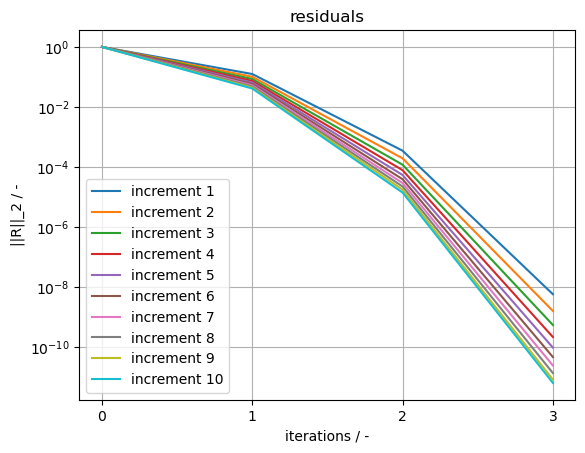

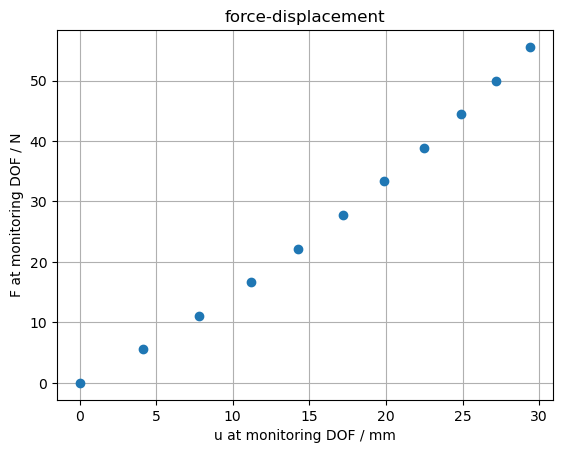

In [3]:
# plot residuals
post.plots.residuals(solver_SVK.monitoring)

# plot results
post.plots.force_displacement(solver_SVK.monitoring)

Finally, we want to visualize the field results, namely the displacement and the pushed-forward Cauchy stress $\sigma$. Note that for the latter, we need to project the values from the Gauss points to the nodes for visualization (this is common in FE programs), which -- if you're curious -- you can find in `nlfea/post/gausspoint_to_nodes.py`. With the chosen BCs, you should see a homogeneous stress state (up to numerical round-off errors).

In [4]:
post.interactive.continuum(solver_SVK.result_dir, field="u")
post.interactive.continuum(solver_SVK.result_dir, field="σ")

Widget(value='<iframe src="http://localhost:60478/index.html?ui=P_0x1ec80a7fa10_0&reconnect=auto" class="pyvis…

Widget(value='<iframe src="http://localhost:60478/index.html?ui=P_0x1ec834220d0_1&reconnect=auto" class="pyvis…

## 2. Implementation of hyperelastic material laws

Next, we devote ourselves to the implementation of hyperelastic material laws.
While before, we've been using the St. Venant-Kirchhoff material model, we now want to use a neo-Hookean material.

**TASK 3:** Implement the missing definitions of the Mooney-Rivlin material model in `nlfea/materials/neo_hooke.py`.

With your implementation, run the same test setup.

model dimension:		2
chosen element:			quad4
number of nodes:		500
number of elements:		441
number of DOFs:			1000

___________________________________________________________________________ 
increment: 0
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=0.07779064596107728
		iteration: 2, residual_norm=9.524819300779625e-05
		iteration: 3, residual_norm=2.099998147988228e-10
___________________________________________________________________________ 
increment: 1
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=0.083063917688012
		iteration: 2, residual_norm=9.855437983452198e-05
		iteration: 3, residual_norm=2.12067161406524e-10
___________________________________________________________________________ 
increment: 2
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=0.08869274628248694
		iteration: 2, residual_norm=0.00010065076946740579
		iteration: 3, residual_norm=2.0561144446932657e-10
____________________________________________________

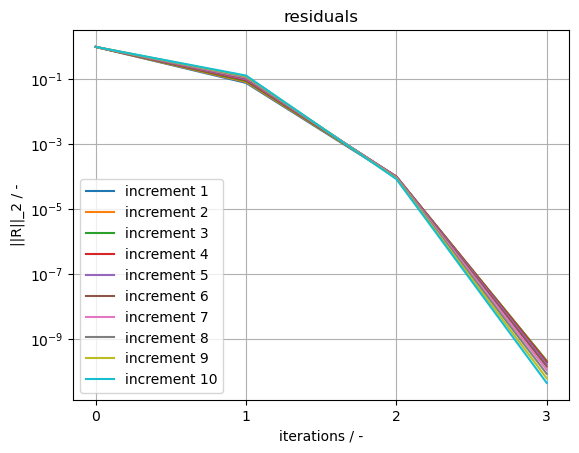

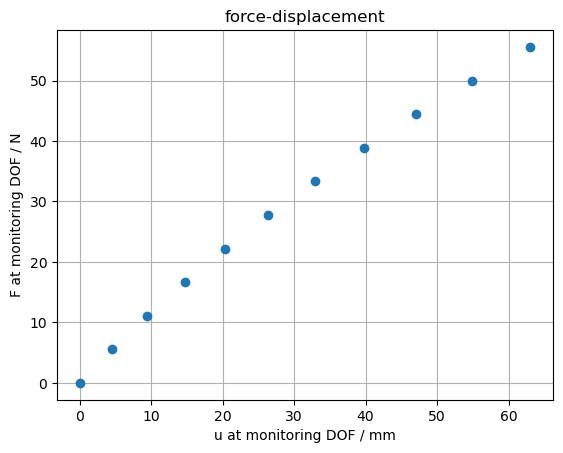

In [5]:
# initialize empty model object
model_NH = Model()

# mesh
W = 10
L = 100
(model_NH.nodes, model_NH.connectivity) = mesh.plane.rectangle(
    length_x=W, length_y=L, num_nodes_x=10, num_nodes_y=50, element_type="quad4"
)

# define material model
model_NH.material = materials.NeoHooke(λ=121, μ=80)

# define type of element
model_NH.parent_element = elements.Quad(
    kinematics="nonlinear", element_type="quad4", integration="full"
)


# find node sets for the application of BCs
bottom_edge = mesh.nodesets.find(model_NH.nodes, Y=0)
bottom_leftcorner = mesh.nodesets.find(model_NH.nodes, X=0, Y=0)
top_edge = mesh.nodesets.find(model_NH.nodes, Y=L)

# Dirichlet BCs
model_NH.dirichlet_bcs = (("fix_X", bottom_leftcorner), ("fix_Y", bottom_edge))

# Neumann BCs
t_bar = 100
model_NH.neumann_bcs = (("t_Y", top_edge, t_bar),)

# solver parameters
solver_NH = Solver()
solver_NH.num_increments = 10
solver_NH.tolerance_nr = 1e-7
solver_NH.max_iter = 20
solver_NH.control_method = "load"

# get DOF used for the monitoring in the plots
monitoring_node = mesh.nodesets.find(model_NH.nodes, X=W, Y=L)
monitoring_node_dof = np.array([[monitoring_node[0], 1]])
solver_NH.monitoring_dof = int(
    monitoring_node_dof[0, 0] * 2 + monitoring_node_dof[0, 1]
)

# set output directory
solver_NH.result_dir = "project3_NH"

# preprocess model and start computations
model_NH.prepare()
solution.incremental.solve(model_NH, solver_NH)

# plot residuals
post.plots.residuals(solver_NH.monitoring)

# plot results
post.plots.force_displacement(solver_NH.monitoring)

Finally, we again want to visualize the field results, namely the displacement and the pushed-forward Cauchy stress $\sigma$.

In [6]:
post.interactive.continuum(solver_NH.result_dir, field="u")
post.interactive.continuum(solver_NH.result_dir, field="σ")

Widget(value='<iframe src="http://localhost:60478/index.html?ui=P_0x1ec83423390_2&reconnect=auto" class="pyvis…

Widget(value='<iframe src="http://localhost:60478/index.html?ui=P_0x1ec9723b110_3&reconnect=auto" class="pyvis…

## 3. Application

Finally, to test your implementation with a more interesting test setup, you can run a common test called 'Cooke's membrane', where a traction load is applied on the right edge.

model dimension:		2
chosen element:			quad4
number of nodes:		625
number of elements:		576
number of DOFs:			1250

___________________________________________________________________________ 
increment: 0
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=2.767827541277199
		iteration: 2, residual_norm=0.006474312567706752
		iteration: 3, residual_norm=5.12238923227974e-06
		iteration: 4, residual_norm=4.227198451773636e-11
___________________________________________________________________________ 
increment: 1
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=2.566854896120266
		iteration: 2, residual_norm=0.0055233662073178565
		iteration: 3, residual_norm=5.093242233651554e-06
		iteration: 4, residual_norm=4.295380921270985e-11
___________________________________________________________________________ 
increment: 2
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=2.361294691501623
		iteration: 2, residual_norm=0.004613484464024119
		iterat

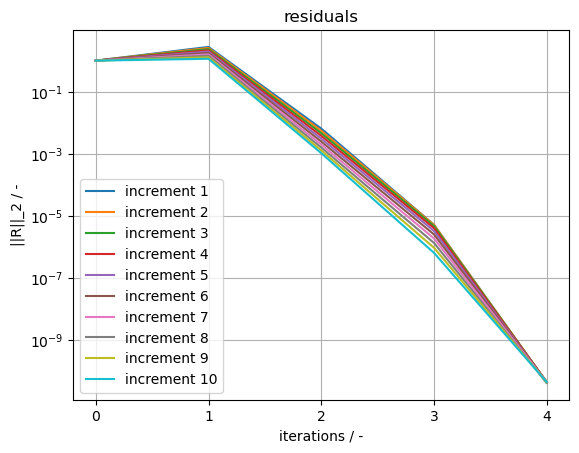

Widget(value='<iframe src="http://localhost:60478/index.html?ui=P_0x1ec9f778690_4&reconnect=auto" class="pyvis…

In [7]:
# initialize empty model object
model = Model()

# mesh
(model.nodes, model.connectivity) = mesh.plane.cooksmembrane(
    num_nodes_x=25, num_nodes_y=25, element_type="quad4"
)

# define type of element
model.parent_element = elements.Quad(
    kinematics="nonlinear", element_type="quad4", integration="full"
)

# material
model.material = materials.NeoHooke(λ=121, μ=40)

# find node sets for the application of BCs
left_edge = mesh.nodesets.find(model.nodes, X=0)
right_edge = mesh.nodesets.find(model.nodes, X=max(model.nodes[:, 0]))

# Dirichlet BCs
model.dirichlet_bcs = (("fix_X", left_edge), ("fix_Y", left_edge))

# Neumann BCs
model.neumann_bcs = (("t_Y", right_edge, 5),)

# solver parameters
solver = Solver()
solver.num_increments = 10
solver.tolerance_nr = 1e-7
solver.max_iter = 20
solver.control_method = "load"

# get DOF used for the monitoring in the plots
monitoring_node = mesh.nodesets.find(
    model.nodes, X=max(model.nodes[:, 0]), Y=max(model.nodes[:, 1])
)
monitoring_node_dof = np.array([[monitoring_node[0], 0]])
solver.monitoring_dof = int(monitoring_node_dof[0, 0] * 2 + monitoring_node_dof[0, 1])

# set output directory
solver.result_dir = "misc_cooksmembrane"

# preprocess model and start computations
model.prepare()
solution.incremental.solve(model, solver)

# plot residuals
post.plots.residuals(solver.monitoring)

# plot deformed mesh
post.interactive.continuum(solver.result_dir)


For the submission of this project, upload on Moodle:

- this Jupyter notebook,
- the file `elements/shape_functions.py`,
- the file `elements/quad.py`, and
- the file `materials/neo_hooke.py`.